In [1]:
import pandas as pd
import numpy as np
import urllib
import matplotlib.pyplot as plt
# url = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/datasets/housing/housing.csv"
# urllib.request.urlretrieve(url,"housing.csv")
housing = pd.read_csv("datasets/housing.csv");
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


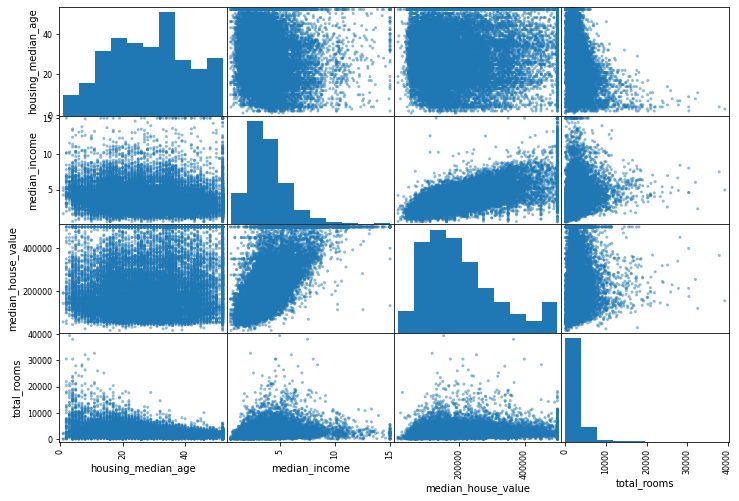

In [2]:
# EDA, scatterplot matrix
from pandas.plotting import scatter_matrix 
attrs=["housing_median_age","median_income","median_house_value","total_rooms"]
scatter_matrix(housing[attrs],figsize=(12,8));

In [3]:
housing["rooms_per_household"]= housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]= housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]= housing["population"]/housing["households"]

housing.drop("total_bedrooms",axis=1)
housing_num = housing.drop("ocean_proximity",axis=1)

In [4]:
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[["ocean_proximity"]]
encoder = OneHotEncoder()
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# custom transformer ?????????????????
from sklearn.base import BaseEstimator, TransformerMixin
col_names = "total_rooms", "total_bedrooms", "population", "households"
# rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                            bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()


num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    # transformers from ("num",num_pipeline,num_attribs),
    ("imputer",SimpleImputer(strategy="median")),
    ("attribs_adder",CombinedAttributesAdder()),
    ("std_scaler",StandardScaler()),
    ("cat",OneHotEncoder(),cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
# training with linear regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fig(housing_prepared,housing_labels)
